# Actions actually doing something or not

In [35]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image, PngImagePlugin

# Define the latest myopic ID
myopic_latest_id = 757

# Define the corresponding proactive and older runs
proactive_latest_id = myopic_latest_id - 1
myopic_2 = myopic_latest_id - 2
proactive_2 = myopic_latest_id - 3
myopic_3 = myopic_latest_id - 4
proactive_3 = myopic_latest_id - 5

# File paths to all runs
myopic_ids = [myopic_latest_id, myopic_2, myopic_3]
proactive_ids = [proactive_latest_id, proactive_2, proactive_3]

myopic_file_paths = [f"../logs/training/training_{mid:04d}.json" for mid in myopic_ids]
proactive_file_paths = [f"../logs/training/training_{pid:04d}.json" for pid in proactive_ids]

print(f"Myopic IDs: {myopic_ids}")
print(f"Proactive IDs: {proactive_ids}")

# Load all JSON data
myopic_data_list = []
proactive_data_list = []
for path in myopic_file_paths:
    with open(path, 'r') as file:
        myopic_data_list.append(json.load(file))
for path in proactive_file_paths:
    with open(path, 'r') as file:
        proactive_data_list.append(json.load(file))


Myopic IDs: [757, 755, 753]
Proactive IDs: [756, 754, 752]


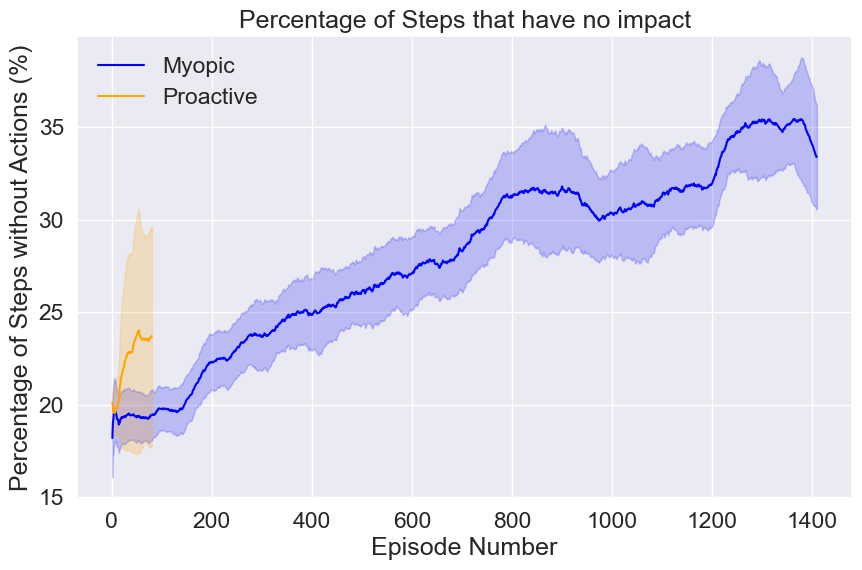

In [36]:
import pandas as pd
from PIL import Image, PngImagePlugin

def calculate_episode_percentages(data):
    episode_percentages = []
    for episode_number in data['episodes']:
        episode_data = data['episodes'][episode_number]
        
        total_steps = 0
        steps_without_action = 0
        
        for scenario_number in episode_data['scenarios']:
            scenario_data = episode_data['scenarios'][scenario_number]
            for step_data in scenario_data['steps']:
                total_steps += 1
                # Check if something happened
                if 'something_happened' not in step_data['info_after_step'] or step_data['info_after_step']['something_happened'] != 1:
                    steps_without_action += 1
        
        if total_steps > 0:
            percentage = (steps_without_action / total_steps) * 100
            episode_percentages.append(percentage)
    
    return episode_percentages

def aggregate_runs_percentages(data_list):
    # Calculate episode percentages for each run
    all_runs = [calculate_episode_percentages(d) for d in data_list]
    
    min_len = min(len(run) for run in all_runs)
    aligned_runs = [run[:min_len] for run in all_runs]
    stacked = np.array(aligned_runs)  # shape: (num_runs, episodes)
    
    mean_values = np.mean(stacked, axis=0)
    std_values = np.std(stacked, axis=0)
    return mean_values, std_values



# Aggregate myopic and proactive runs
episode_percentages_myopic_mean, episode_percentages_myopic_std = aggregate_runs_percentages(myopic_data_list)
episode_percentages_proactive_mean, episode_percentages_proactive_std = aggregate_runs_percentages(proactive_data_list)

# Define window size for smoothing
WINDOW_SIZE = 40

def smooth_series(series, window=40):
    return pd.Series(series).rolling(window=window, min_periods=1).mean().values

myopic_steps = np.arange(1, len(episode_percentages_myopic_mean)+1)
proactive_steps = np.arange(1, len(episode_percentages_proactive_mean)+1)

myopic_mean_sm = smooth_series(episode_percentages_myopic_mean, WINDOW_SIZE)
myopic_std_sm = smooth_series(episode_percentages_myopic_std, WINDOW_SIZE)
proactive_mean_sm = smooth_series(episode_percentages_proactive_mean, WINDOW_SIZE)
proactive_std_sm = smooth_series(episode_percentages_proactive_std, WINDOW_SIZE)

# Plot with fill_between for percentage of steps without actions
plt.figure(figsize=(10, 6))
plt.plot(myopic_steps, myopic_mean_sm, label="Myopic", color='blue')
plt.fill_between(myopic_steps, myopic_mean_sm - myopic_std_sm, myopic_mean_sm + myopic_std_sm, alpha=0.2, color='blue')

plt.plot(proactive_steps, proactive_mean_sm, label="Proactive", color='orange')
plt.fill_between(proactive_steps, proactive_mean_sm - proactive_std_sm, proactive_mean_sm + proactive_std_sm, alpha=0.2, color='orange')

plt.xlabel('Episode Number')
plt.ylabel('Percentage of Steps without Actions (%)')
plt.title('Percentage of Steps that have no impact')
plt.legend(frameon=False)
plt.grid(True)
plt.show()



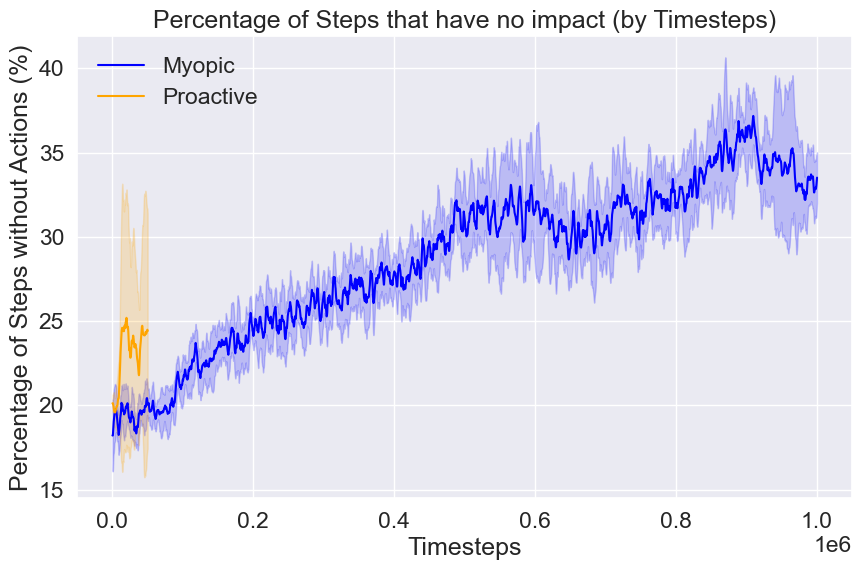

In [41]:
def extract_cumulative_steps(data):
    """Extract the cumulative number of steps after each episode for a single run."""
    cumulative_steps = []
    total_so_far = 0
    for episode_number in data['episodes']:
        episode_data = data['episodes'][episode_number]
        episode_steps = 0
        for scenario_number in episode_data['scenarios']:
            scenario_data = episode_data['scenarios'][scenario_number]
            episode_steps += len(scenario_data['steps'])
        total_so_far += episode_steps
        cumulative_steps.append(total_so_far)
    return np.array(cumulative_steps)

def get_all_cumulative_steps_and_percentages(data_list):
    """For each run in data_list, return (cumulative_steps, percentages) arrays."""
    runs_steps = []
    runs_percentages = []
    for d in data_list:
        # Extract episode-level percentages again
        episode_percentages = []
        episode_steps_cumulative = []
        total_so_far = 0
        for episode_number in d['episodes']:
            episode_data = d['episodes'][episode_number]
            
            total_steps = 0
            steps_without_action = 0
            for scenario_number in episode_data['scenarios']:
                scenario_data = episode_data['scenarios'][scenario_number]
                for step_data in scenario_data['steps']:
                    total_steps += 1
                    # Check if something happened
                    if 'something_happened' not in step_data['info_after_step'] \
                       or step_data['info_after_step']['something_happened'] != 1:
                        steps_without_action += 1
            
            if total_steps > 0:
                percentage = (steps_without_action / total_steps) * 100
                episode_percentages.append(percentage)
                
                total_so_far += total_steps
                episode_steps_cumulative.append(total_so_far)
        
        runs_steps.append(np.array(episode_steps_cumulative))
        runs_percentages.append(np.array(episode_percentages))
    return runs_steps, runs_percentages

myopic_runs_steps, myopic_runs_percentages = get_all_cumulative_steps_and_percentages(myopic_data_list)
proactive_runs_steps, proactive_runs_percentages = get_all_cumulative_steps_and_percentages(proactive_data_list)

def get_min_final_steps(runs_steps):
    # Eachlast element of each array is the final timestep of that run
    return min(steps_array[-1] for steps_array in runs_steps if len(steps_array) > 0)

min_final_steps_myopic = get_min_final_steps(myopic_runs_steps)
min_final_steps_proactive = get_min_final_steps(proactive_runs_steps)

stride = 100
common_timestep_axis_myopic = np.arange(stride, min_final_steps_myopic+1, stride)
common_timestep_axis_proactive = np.arange(stride, min_final_steps_proactive+1, stride)

def interpolate_runs_to_common_steps(runs_steps, runs_percentages, common_axis):
    aligned_runs = []
    for steps, perc in zip(runs_steps, runs_percentages):
        if len(steps) == 0:
            continue
        
        steps_with_zero = np.concatenate(([0], steps))
        perc_with_zero = np.concatenate(([perc[0]], perc)) 
        aligned_perc = np.interp(common_axis, steps_with_zero, perc_with_zero)
        aligned_runs.append(aligned_perc)
    if len(aligned_runs) == 0:
        return None, None
    aligned_runs = np.array(aligned_runs)
    mean_values = aligned_runs.mean(axis=0)
    std_values = aligned_runs.std(axis=0)
    return mean_values, std_values

myopic_mean_steps, myopic_std_steps = interpolate_runs_to_common_steps(myopic_runs_steps, myopic_runs_percentages, common_timestep_axis_myopic)
proactive_mean_steps, proactive_std_steps = interpolate_runs_to_common_steps(proactive_runs_steps, proactive_runs_percentages, common_timestep_axis_proactive)

# Smooth the new step-based arrays
myopic_mean_sm = smooth_series(myopic_mean_steps, WINDOW_SIZE)
myopic_std_sm = smooth_series(myopic_std_steps, WINDOW_SIZE)
proactive_mean_sm = smooth_series(proactive_mean_steps, WINDOW_SIZE)
proactive_std_sm = smooth_series(proactive_std_steps, WINDOW_SIZE)

# Plot with timesteps as the x-axis
plt.figure(figsize=(10, 6))
plt.plot(common_timestep_axis_myopic, myopic_mean_sm, label="Myopic", color='blue')
plt.fill_between(common_timestep_axis_myopic, myopic_mean_sm - myopic_std_sm, myopic_mean_sm + myopic_std_sm, alpha=0.2, color='blue')

plt.plot(common_timestep_axis_proactive, proactive_mean_sm, label="Proactive", color='orange')
plt.fill_between(common_timestep_axis_proactive, proactive_mean_sm - proactive_std_sm, proactive_mean_sm + proactive_std_sm, alpha=0.2, color='orange')

plt.xlabel('Timesteps')
plt.ylabel('Percentage of Steps without Actions (%)')
plt.title('Percentage of Steps that have no impact (by Timesteps)')
plt.legend(frameon=False)
plt.grid(True)
plt.show()


# Reward distribution

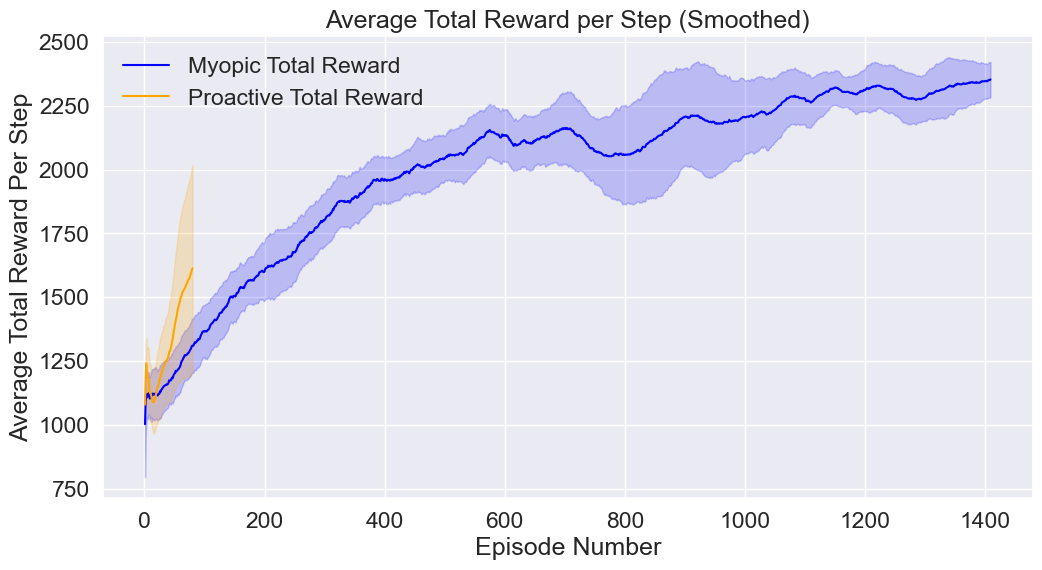

In [37]:

def calculate_rewards_per_step(data):
    rewards_total = []
    rewards_conflict_resolution = []
    rewards_delay = []
    rewards_cancelled = []
    rewards_inaction = []
    rewards_proactive = []
    rewards_time_progression = []
    
    for episode_number in data['episodes']:
        episode_data = data['episodes'][episode_number]
        
        total_steps = 0
        episode_total = 0
        episode_conflict = 0
        episode_delay = 0
        episode_cancelled = 0
        episode_inaction = 0
        episode_proact = 0
        episode_time = 0
        
        for scenario_number in episode_data['scenarios']:
            scenario_data = episode_data['scenarios'][scenario_number]
            steps = len(scenario_data['steps'])
            total_steps += steps
            
            for step_data in scenario_data['steps']:
                info = step_data['info_after_step']
                episode_total += step_data['reward']
                episode_conflict += info.get('conflict_resolution_reward', 0)
                episode_delay -= info.get('delay_penalty_total', 0)
                episode_cancelled -= info.get('cancellation_penalty', 0)
                episode_inaction -= info.get('inaction_penalty', 0)
                episode_proact += info.get('proactive_bonus', 0)
                episode_time -= info.get('time_penalty', 0)
        
        if total_steps > 0:
            rewards_total.append(episode_total / total_steps)
            rewards_conflict_resolution.append(episode_conflict / total_steps)
            rewards_delay.append(episode_delay / total_steps)
            rewards_cancelled.append(episode_cancelled / total_steps)
            rewards_inaction.append(episode_inaction / total_steps)
            rewards_proactive.append(episode_proact / total_steps)
            rewards_time_progression.append(episode_time / total_steps)
    
    return (rewards_total, rewards_conflict_resolution, rewards_delay, 
            rewards_cancelled, rewards_inaction, rewards_proactive, 
            rewards_time_progression)

def aggregate_rewards(data_list):
    # Calculate rewards for each run
    runs = [calculate_rewards_per_step(d) for d in data_list]
    
    # Each element of runs is a tuple of 7 lists.
    # First find the minimum length across all runs for alignment:
    min_len = min(len(r[0]) for r in runs)  # length of rewards_total in each run
    # Align all
    aligned_runs = []
    for run in runs:
        aligned_run = [arr[:min_len] for arr in run]  # truncate each array
        aligned_runs.append(aligned_run)
    
    # Now aligned_runs is a list of tuples, each tuple has 7 lists of equal length
    # Stack each component and compute mean/std
    # For index i in the tuple: stack aligned_runs for that component
    def stack_and_aggregate(i):
        comp = np.array([run[i] for run in aligned_runs])  # shape: (num_runs, episodes)
        return np.mean(comp, axis=0), np.std(comp, axis=0)
    
    means_stds = [stack_and_aggregate(i) for i in range(7)]
    # means_stds is a list of (mean, std) pairs for each reward component
    return means_stds, min_len

# Aggregate myopic rewards
(myopic_rewards_all, myopic_len) = aggregate_rewards(myopic_data_list)
(proactive_rewards_all, proactive_len) = aggregate_rewards(proactive_data_list)

# myopic_rewards_all[0] is (means, std) for total rewards
(rewards_total_myopic_mean, rewards_total_myopic_std) = myopic_rewards_all[0]
(rewards_total_proactive_mean, rewards_total_proactive_std) = proactive_rewards_all[0]

myopic_steps_rewards = np.arange(1, myopic_len+1)
proactive_steps_rewards = np.arange(1, proactive_len+1)

rewards_total_myopic_smooth = smooth_series(rewards_total_myopic_mean, WINDOW_SIZE)
rewards_total_myopic_std_smooth = smooth_series(rewards_total_myopic_std, WINDOW_SIZE)
rewards_total_proactive_smooth = smooth_series(rewards_total_proactive_mean, WINDOW_SIZE)
rewards_total_proactive_std_smooth = smooth_series(rewards_total_proactive_std, WINDOW_SIZE)

# Plot total average reward per step with std
plt.figure(figsize=(12, 6))
plt.plot(myopic_steps_rewards, rewards_total_myopic_smooth, label='Myopic Total Reward', color='blue')
plt.fill_between(myopic_steps_rewards, 
                 rewards_total_myopic_smooth - rewards_total_myopic_std_smooth, 
                 rewards_total_myopic_smooth + rewards_total_myopic_std_smooth, 
                 alpha=0.2, color='blue')

plt.plot(proactive_steps_rewards, rewards_total_proactive_smooth, label='Proactive Total Reward', color='orange')
plt.fill_between(proactive_steps_rewards, 
                 rewards_total_proactive_smooth - rewards_total_proactive_std_smooth, 
                 rewards_total_proactive_smooth + rewards_total_proactive_std_smooth, 
                 alpha=0.2, color='orange')

plt.xlabel('Episode Number')
plt.ylabel('Average Total Reward Per Step')
plt.title('Average Total Reward per Step (Smoothed)')
plt.legend(frameon=False)
plt.grid(True)
plt.show()


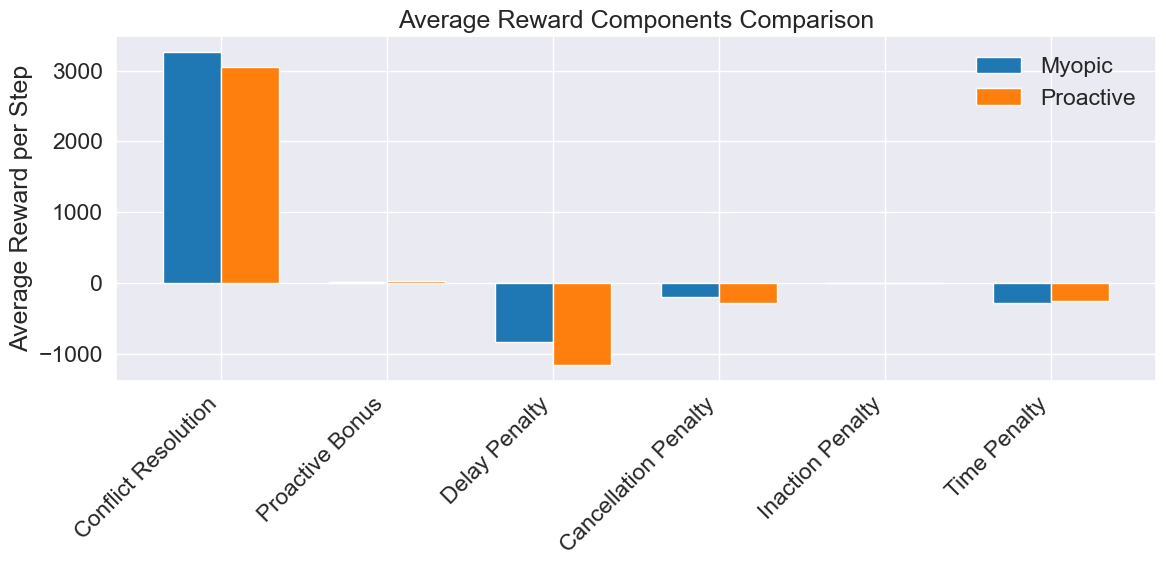

In [38]:
components = ['Conflict Resolution', 'Proactive Bonus', 'Delay Penalty', 'Cancellation Penalty', 'Inaction Penalty', 'Time Penalty']
conflict_idx = 1
proactive_idx = 5
delay_idx = 2
cancelled_idx = 3
inaction_idx = 4
time_idx = 6

# Compute the mean across episodes for each component
def mean_across_episodes(mean_array):
    return np.mean(mean_array)

avg_components_myopic = [
    mean_across_episodes(myopic_rewards_all[conflict_idx][0]),
    mean_across_episodes(myopic_rewards_all[proactive_idx][0]),
    mean_across_episodes(myopic_rewards_all[delay_idx][0]),
    mean_across_episodes(myopic_rewards_all[cancelled_idx][0]),
    mean_across_episodes(myopic_rewards_all[inaction_idx][0]),
    mean_across_episodes(myopic_rewards_all[time_idx][0])
]

avg_components_proactive = [
    mean_across_episodes(proactive_rewards_all[conflict_idx][0]),
    mean_across_episodes(proactive_rewards_all[proactive_idx][0]),
    mean_across_episodes(proactive_rewards_all[delay_idx][0]),
    mean_across_episodes(proactive_rewards_all[cancelled_idx][0]),
    mean_across_episodes(proactive_rewards_all[inaction_idx][0]),
    mean_across_episodes(proactive_rewards_all[time_idx][0])
]

x = np.arange(len(components))
bar_width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - bar_width/2, avg_components_myopic, bar_width, label='Myopic', color='#1f77b4')
rects2 = ax.bar(x + bar_width/2, avg_components_proactive, bar_width, label='Proactive', color='#ff7f0e')

ax.set_ylabel('Average Reward per Step')
ax.set_title('Average Reward Components Comparison')
ax.set_xticks(x)
ax.set_xticklabels(components, rotation=45, ha='right')
ax.legend(frameon=False)

fig.tight_layout()
plt.show()

# Available actions for the agent per step

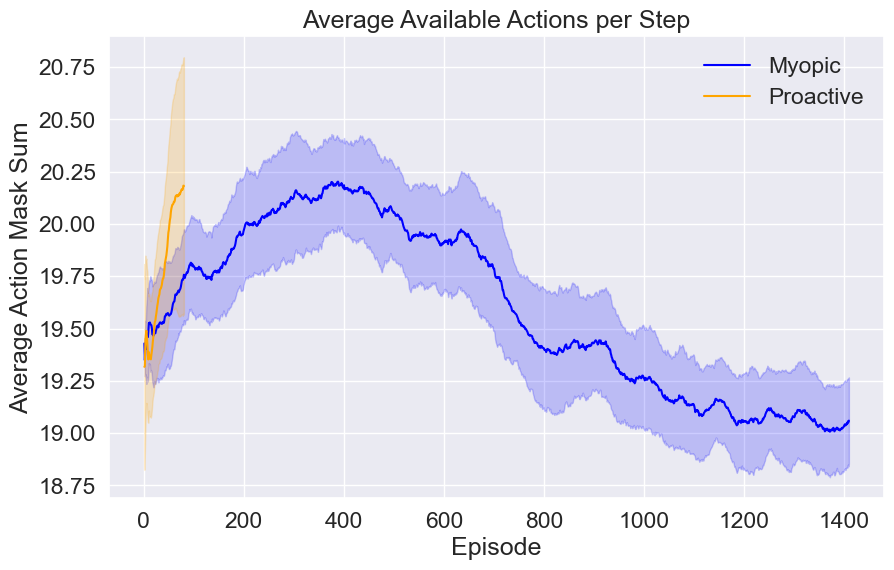

In [39]:

def calculate_average_available_actions(data):
    episode_action_sums = []
    episodes = []
    
    for episode_number in data['episodes']:
        episode_data = data['episodes'][episode_number]
        total_action_mask_sum = 0
        step_count = 0
    
        for scenario_number in episode_data['scenarios']:
            scenario_data = episode_data['scenarios'][scenario_number]
            for step_data in scenario_data['steps']:
                total_action_mask_sum += step_data['action_mask_sum']
                step_count += 1
        
        if step_count > 0:
            average_action_mask = total_action_mask_sum / step_count
            episode_action_sums.append(average_action_mask)
            episodes.append(int(episode_number))
    
    return episodes, episode_action_sums

def aggregate_actions(data_list):
    # Compute actions per run
    runs = [calculate_average_available_actions(d) for d in data_list]
    
    min_len = min(len(r[1]) for r in runs)  # length of avg_actions array
    aligned_actions = [r[1][:min_len] for r in runs]
    stacked = np.array(aligned_actions)  # shape (num_runs, episodes)
    return np.mean(stacked, axis=0), np.std(stacked, axis=0), min_len

myopic_actions_mean, myopic_actions_std, myopic_actions_len = aggregate_actions(myopic_data_list)
proactive_actions_mean, proactive_actions_std, proactive_actions_len = aggregate_actions(proactive_data_list)

myopic_steps_actions = np.arange(1, myopic_actions_len+1)
proactive_steps_actions = np.arange(1, proactive_actions_len+1)

myopic_actions_mean_sm = smooth_series(myopic_actions_mean, WINDOW_SIZE)
myopic_actions_std_sm = smooth_series(myopic_actions_std, WINDOW_SIZE)
proactive_actions_mean_sm = smooth_series(proactive_actions_mean, WINDOW_SIZE)
proactive_actions_std_sm = smooth_series(proactive_actions_std, WINDOW_SIZE)

plt.figure(figsize=(10, 6))
plt.plot(myopic_steps_actions, myopic_actions_mean_sm, label='Myopic', color='blue')
plt.fill_between(myopic_steps_actions, 
                 myopic_actions_mean_sm - myopic_actions_std_sm, 
                 myopic_actions_mean_sm + myopic_actions_std_sm, 
                 alpha=0.2, color='blue')

plt.plot(proactive_steps_actions, proactive_actions_mean_sm, label='Proactive', color='orange')
plt.fill_between(proactive_steps_actions, 
                 proactive_actions_mean_sm - proactive_actions_std_sm, 
                 proactive_actions_mean_sm + proactive_actions_std_sm, 
                 alpha=0.2, color='orange')

plt.title('Average Available Actions per Step')
plt.xlabel('Episode')
plt.ylabel('Average Action Mask Sum')
plt.legend(frameon=False)
plt.grid(True)
plt.show()

# Steps to resolve a disrupted scenario

## Total

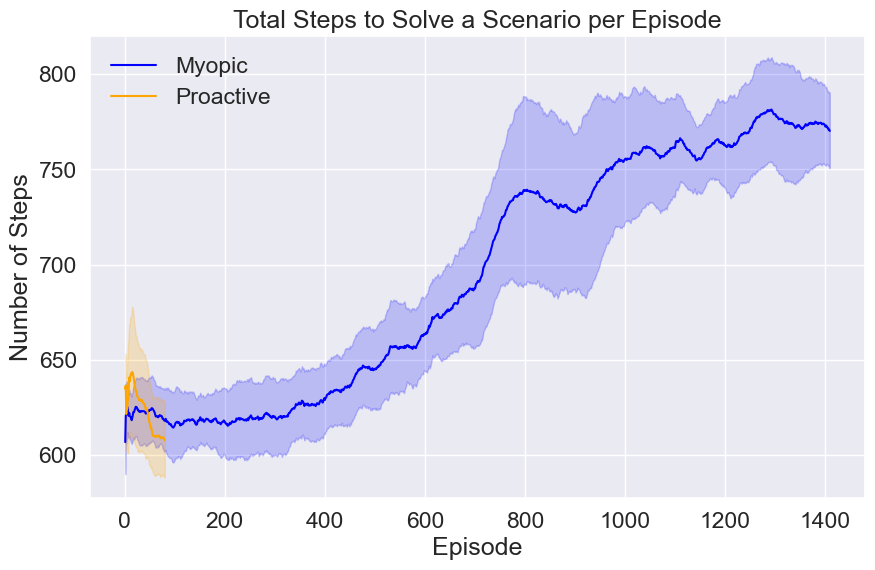

In [40]:
def calculate_total_steps_per_episode(data):
    episode_step_counts = []
    episodes = []
    
    for episode_number in data['episodes']:
        episode_data = data['episodes'][episode_number]
        total_steps = 0
    
        for scenario_number in episode_data['scenarios']:
            scenario_data = episode_data['scenarios'][scenario_number]
            total_steps += len(scenario_data['steps'])
        
        episode_step_counts.append(total_steps)
        episodes.append(int(episode_number))
    
    return episodes, episode_step_counts

def aggregate_steps(data_list):
    # Compute steps per run
    runs = [calculate_total_steps_per_episode(d) for d in data_list]
    # runs is a list of tuples (episodes, steps) for each run
    # Align by the minimum length
    min_len = min(len(r[1]) for r in runs)
    aligned_steps = [r[1][:min_len] for r in runs]
    
    stacked = np.array(aligned_steps)  # shape (num_runs, episodes)
    mean_values = np.mean(stacked, axis=0)
    std_values = np.std(stacked, axis=0)
    return mean_values, std_values, min_len

# Aggregate for myopic and proactive
steps_myopic_mean, steps_myopic_std, myopic_len = aggregate_steps(myopic_data_list)
steps_proactive_mean, steps_proactive_std, proactive_len = aggregate_steps(proactive_data_list)

# Create episode indices
myopic_steps_idx = np.arange(1, myopic_len+1)
proactive_steps_idx = np.arange(1, proactive_len+1)

# Smooth data
steps_myopic_mean_sm = pd.Series(steps_myopic_mean).rolling(window=WINDOW_SIZE, min_periods=1).mean().values
steps_myopic_std_sm = pd.Series(steps_myopic_std).rolling(window=WINDOW_SIZE, min_periods=1).mean().values
steps_proactive_mean_sm = pd.Series(steps_proactive_mean).rolling(window=WINDOW_SIZE, min_periods=1).mean().values
steps_proactive_std_sm = pd.Series(steps_proactive_std).rolling(window=WINDOW_SIZE, min_periods=1).mean().values

# Plot
plt.figure(figsize=(10, 6))
plt.plot(myopic_steps_idx, steps_myopic_mean_sm, label='Myopic', color='blue')
plt.fill_between(myopic_steps_idx, 
                 steps_myopic_mean_sm - steps_myopic_std_sm, 
                 steps_myopic_mean_sm + steps_myopic_std_sm, 
                 alpha=0.2, color='blue')

plt.plot(proactive_steps_idx, steps_proactive_mean_sm, label='Proactive', color='orange')
plt.fill_between(proactive_steps_idx, 
                 steps_proactive_mean_sm - steps_proactive_std_sm, 
                 steps_proactive_mean_sm + steps_proactive_std_sm, 
                 alpha=0.2, color='orange')

plt.title('Total Steps to Solve a Scenario per Episode')
plt.xlabel('Episode')
plt.ylabel('Number of Steps')
plt.legend(frameon=False)
plt.grid(True)
plt.show()


## Average per scenario

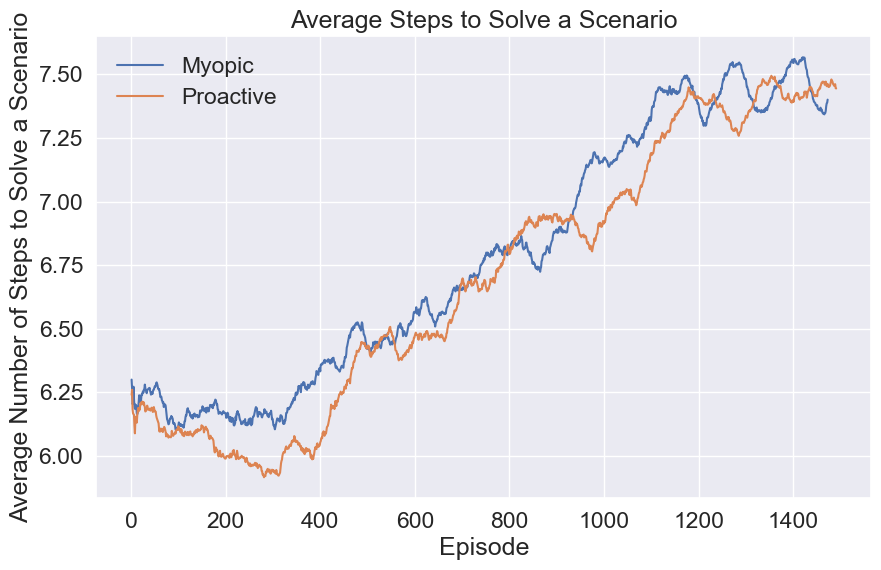

In [23]:
# %%
def calculate_avg_steps_per_scenario(data):
    episode_avg_step_counts = []
    episodes = []
    
    # Process data
    for episode_number in data['episodes']:
        episode_data = data['episodes'][episode_number]
        total_steps = 0
        num_scenarios = len(episode_data['scenarios'])
    
        for scenario_number in episode_data['scenarios']:
            scenario_data = episode_data['scenarios'][scenario_number]
            total_steps += len(scenario_data['steps'])
        
        # Calculate average steps per scenario
        avg_steps = total_steps / num_scenarios if num_scenarios > 0 else 0
        episode_avg_step_counts.append(avg_steps)
        episodes.append(int(episode_number))
    
    return episodes, episode_avg_step_counts

# Calculate for both datasets
episodes_myopic, avg_steps_myopic = calculate_avg_steps_per_scenario(data_myopic)
episodes_proactive, avg_steps_proactive = calculate_avg_steps_per_scenario(data_proactive)

# Plot the data
plt.figure(figsize=(10, 6))
myopic_smooth = pd.Series(avg_steps_myopic).rolling(window=WINDOW_SIZE, min_periods=1).mean()
proactive_smooth = pd.Series(avg_steps_proactive).rolling(window=WINDOW_SIZE, min_periods=1).mean()
plt.plot(episodes_myopic, myopic_smooth, label='Myopic')
plt.plot(episodes_proactive, proactive_smooth, label='Proactive')
plt.title('Average Steps to Solve a Scenario')
plt.xlabel('Episode')
plt.ylabel('Average Number of Steps to Solve a Scenario')
plt.legend(frameon=False)
plt.grid(True)
plt.show()


# Proactive vs. Reactive actions chosen

## Categorized

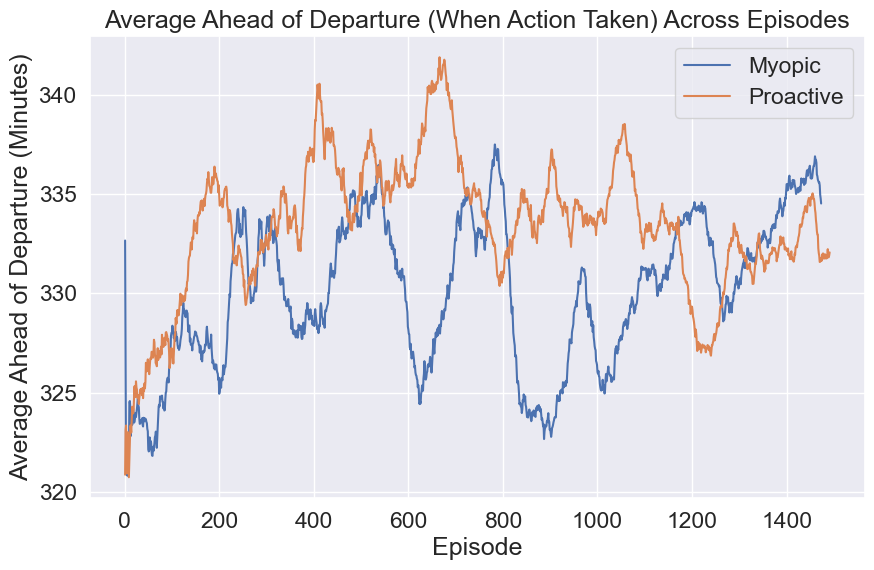

In [25]:
# %%
def calculate_avg_time_to_departure(data):
    episode_avg_time_to_departure = []
    episode_std_time_to_departure = []
    episodes = []
    
    # Iterate through episodes
    for episode_number, episode_data in data['episodes'].items():
        total_time_to_departure = 0
        time_to_departure_values = []
        total_steps_with_action = 0
        
        # Iterate through scenarios in episode
        for scenario_number in episode_data['scenarios']:
            scenario_data = episode_data['scenarios'][scenario_number]
            steps = scenario_data['steps']
            
            # Sum up time to departure for steps where something happened
            for step in steps:
                if step['info_after_step']['something_happened'] == 1:
                    ttd = step['info_after_step'].get('time_to_departure_minutes')
                    if isinstance(ttd, (int, float)):  # Only process numeric values
                        time_to_departure_values.append(ttd)
                        total_time_to_departure += ttd
                        total_steps_with_action += 1
        
        # Calculate average time to departure for the episode
        if total_steps_with_action > 0:
            avg_ttd = total_time_to_departure / total_steps_with_action
            std_dev = np.std(time_to_departure_values) if len(time_to_departure_values) > 1 else 0
            episode_avg_time_to_departure.append(avg_ttd)
            episode_std_time_to_departure.append(std_dev)
            episodes.append(int(episode_number))
    
    return episodes, episode_avg_time_to_departure, episode_std_time_to_departure

# Calculate for both datasets
episodes_myopic, avg_ttd_myopic, std_dev_myopic = calculate_avg_time_to_departure(data_myopic)
episodes_proactive, avg_ttd_proactive, std_dev_proactive = calculate_avg_time_to_departure(data_proactive)

# Plot the data
plt.figure(figsize=(10, 6))
myopic_smooth = pd.Series(avg_ttd_myopic).rolling(window=WINDOW_SIZE, min_periods=1).mean()
proactive_smooth = pd.Series(avg_ttd_proactive).rolling(window=WINDOW_SIZE, min_periods=1).mean()
plt.plot(episodes_myopic, myopic_smooth, label='Myopic')
plt.plot(episodes_proactive, proactive_smooth, label='Proactive')
plt.title('Average Ahead of Departure (When Action Taken) Across Episodes')
plt.xlabel('Episode')
plt.ylabel('Average Ahead of Departure (Minutes)')
plt.legend(frameon=False)
plt.grid(True)
plt.show()


1473
1491


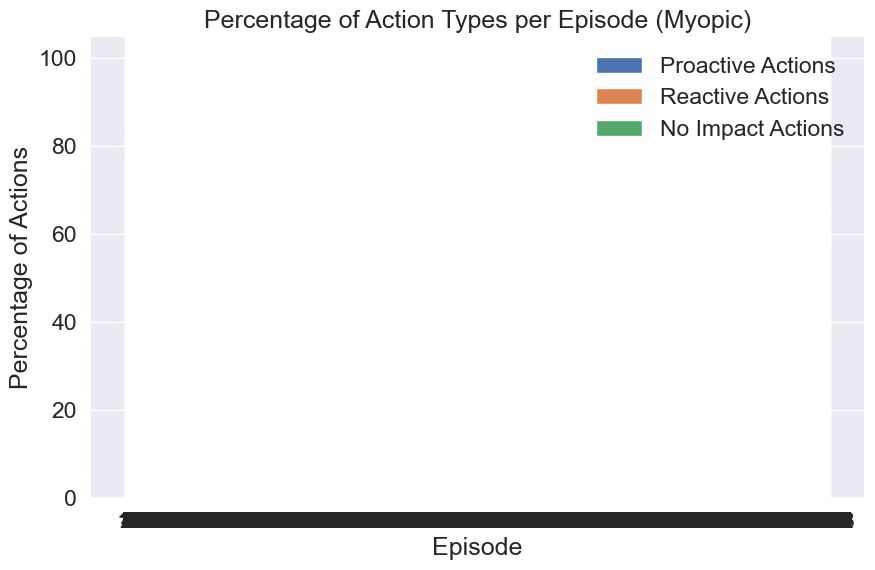

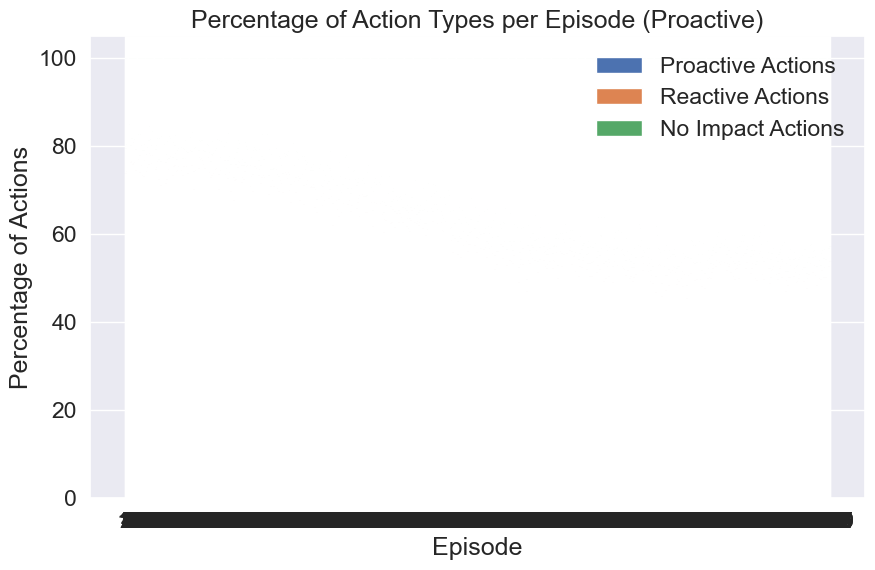

In [27]:

# %%
def calculate_action_types(data, threshold=30):
    # Initialize variables to store proactive and reactive counts per episode
    episode_proactive_counts = []
    episode_reactive_counts = []
    episode_no_impact_counts = []
    episodes = []
    
    # Process data
    for episode_number in data['episodes']:
        episode_data = data['episodes'][episode_number]
        proactive_count = 0
        reactive_count = 0
        no_impact_count = 0
    
        for scenario_number in episode_data['scenarios']:
            scenario_data = episode_data['scenarios'][scenario_number]
            
            for step in scenario_data['steps']:
                if step['info_after_step']['something_happened'] == 1:
                    time_to_departure = step['info_after_step'].get('time_to_departure_minutes')
                    if isinstance(time_to_departure, (int, float)):
                        if time_to_departure > threshold:
                            proactive_count += 1
                        else:
                            reactive_count += 1
                else:
                    no_impact_count += 1
        
        episode_proactive_counts.append(proactive_count)
        episode_reactive_counts.append(reactive_count)
        episode_no_impact_counts.append(no_impact_count)
        episodes.append(int(episode_number))

    print(len(episode_proactive_counts))
    
    return episodes, episode_proactive_counts, episode_reactive_counts, episode_no_impact_counts

# Calculate for both datasets
episodes_myopic, proactive_myopic, reactive_myopic, no_impact_myopic = calculate_action_types(data_myopic)
episodes_proactive, proactive_proactive, reactive_proactive, no_impact_proactive = calculate_action_types(data_proactive)

def plot_stacked_bar(episodes, proactive_counts, reactive_counts, no_impact_counts, label):
    # Calculate total actions per episode
    total_actions = (
        np.array(proactive_counts) 
        + np.array(reactive_counts) 
        + np.array(no_impact_counts)
    )
    
    # Convert counts to percentages
    proactive_percentages = (np.array(proactive_counts) / total_actions) * 100
    reactive_percentages = (np.array(reactive_counts) / total_actions) * 100
    no_impact_percentages = (np.array(no_impact_counts) / total_actions) * 100
    
    # Create stacked bar plot
    plt.figure(figsize=(10, 6))
    x = np.arange(len(episodes))
    
    plt.bar(x, proactive_percentages, label='Proactive Actions')
    plt.bar(x, reactive_percentages, bottom=proactive_percentages, label='Reactive Actions')
    plt.bar(x, no_impact_percentages, 
            bottom=proactive_percentages + reactive_percentages, label='No Impact Actions')
    
    plt.title(f'Percentage of Action Types per Episode ({label})')
    plt.xlabel('Episode')
    plt.ylabel('Percentage of Actions')
    plt.xticks(x, episodes)
    plt.legend(frameon=False)
    plt.grid(True, axis='y')
    plt.show()

# Plot for Myopic
plot_stacked_bar(episodes_myopic, proactive_myopic, reactive_myopic, no_impact_myopic, 'Myopic')

# Plot for Proactive
plot_stacked_bar(episodes_proactive, proactive_proactive, reactive_proactive, no_impact_proactive, 'Proactive')


## Time ahead of departure for action

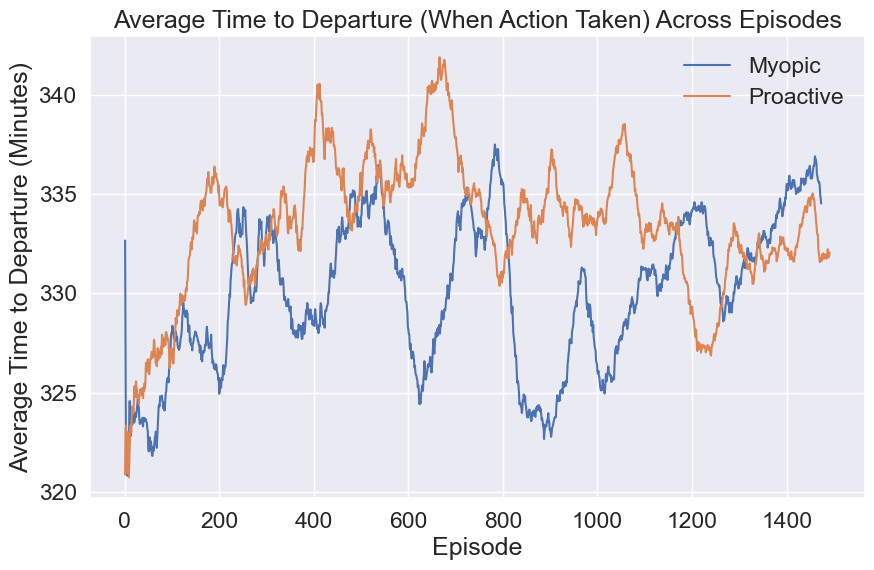

In [43]:
# %%
def calculate_avg_time_to_departure(data):
    episode_avg_time_to_departure = []
    episode_std_time_to_departure = []
    episodes = []

    # Iterate through episodes
    for episode_number, episode_data in data['episodes'].items():
        total_time_to_departure = 0
        time_to_departure_values = []
        total_steps_with_action = 0

        # Iterate through scenarios in episode
        for scenario_number in episode_data['scenarios']:
            scenario_data = episode_data['scenarios'][scenario_number]
            steps = scenario_data['steps']

            # Sum up time to departure for steps where something happened
            for step in steps:
                if step['info_after_step']['something_happened'] == 1:
                    # Check if time_to_departure_minutes is not "None" before processing
                    ttd = step['info_after_step'].get('time_to_departure_minutes')
                    if isinstance(ttd, (int, float)):  # Only process numeric values
                        time_to_departure_values.append(ttd)
                        total_time_to_departure += ttd
                        total_steps_with_action += 1

        # Calculate average time to departure for the episode
        if total_steps_with_action > 0:
            avg_ttd = total_time_to_departure / total_steps_with_action
            std_dev = np.std(time_to_departure_values) if len(time_to_departure_values) > 1 else 0
            episode_avg_time_to_departure.append(avg_ttd)
            episode_std_time_to_departure.append(std_dev)
            episodes.append(int(episode_number))

    return episodes, episode_avg_time_to_departure, episode_std_time_to_departure

# Calculate for both datasets
episodes_myopic, avg_ttd_myopic, std_dev_myopic = calculate_avg_time_to_departure(data_myopic)
episodes_proactive, avg_ttd_proactive, std_dev_proactive = calculate_avg_time_to_departure(data_proactive)

# Plot the data
plt.figure(figsize=(10, 6))
myopic_smooth = pd.Series(avg_ttd_myopic).rolling(window=WINDOW_SIZE, min_periods=1).mean()
proactive_smooth = pd.Series(avg_ttd_proactive).rolling(window=WINDOW_SIZE, min_periods=1).mean()
plt.plot(episodes_myopic, myopic_smooth, label='Myopic')
plt.plot(episodes_proactive, proactive_smooth, label='Proactive')
plt.title('Average Time to Departure (When Action Taken) Across Episodes')
plt.xlabel('Episode')
plt.ylabel('Average Time to Departure (Minutes)')
plt.grid(True)
plt.legend(frameon=False)
plt.show()


# Impact of the last step on the total reward

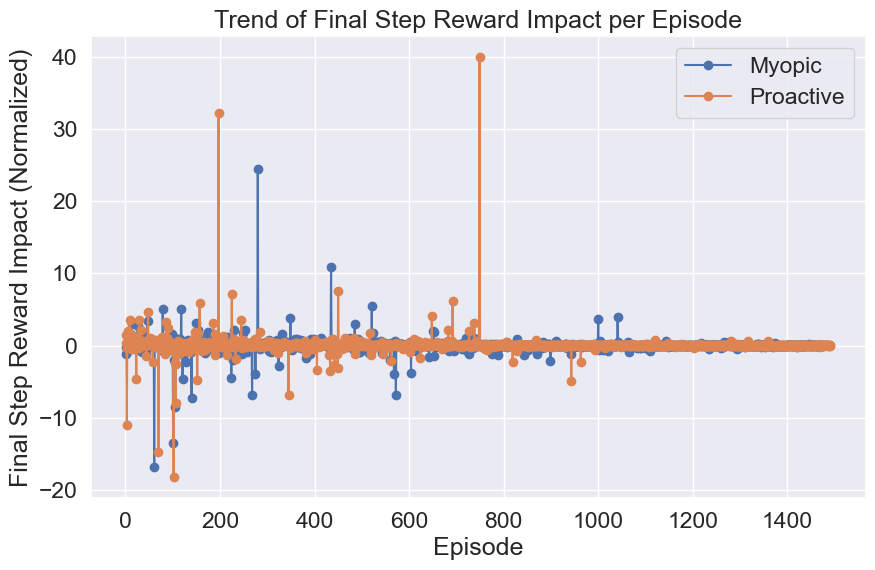

In [10]:
# %%
def calculate_final_step_impact(data):
    episode_final_step_impact = []
    episodes = []
    
    # Iterate through episodes
    for episode_number, episode_data in data['episodes'].items():
        total_final_step_impact = 0
        scenario_count = 0
        
        for scenario_number in episode_data['scenarios']:
            scenario_data = episode_data['scenarios'][scenario_number]
            steps = scenario_data['steps']
            
            if len(steps) > 0:
                # Get total reward from last step
                final_step = steps[-1]
                final_step_reward = final_step['reward']
                
                # Sum up rewards from all steps
                total_reward = sum(step['reward'] for step in steps)
                
                # Calculate normalized contribution of final step to total reward
                if total_reward != 0:  # Avoid division by zero
                    final_step_impact = final_step_reward / total_reward
                    total_final_step_impact += final_step_impact
                    scenario_count += 1
        
        # Calculate average final step impact for the episode
        if scenario_count > 0:
            avg_final_step_impact = total_final_step_impact / scenario_count
            episode_final_step_impact.append(avg_final_step_impact)
            episodes.append(int(episode_number))
        else:
            episode_final_step_impact.append(0)
            episodes.append(int(episode_number))
    
    return episodes, episode_final_step_impact

# Calculate for both datasets
episodes_myopic, final_step_impact_myopic = calculate_final_step_impact(data_myopic)
episodes_proactive, final_step_impact_proactive = calculate_final_step_impact(data_proactive)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(episodes_myopic, final_step_impact_myopic, label='Myopic', marker='o')
plt.plot(episodes_proactive, final_step_impact_proactive, label='Proactive', marker='o')
plt.title('Trend of Final Step Reward Impact per Episode')
plt.xlabel('Episode')
plt.ylabel('Final Step Reward Impact (Normalized)')
plt.legend()
plt.grid(True)
plt.show()


# Delay length disribution - average per step

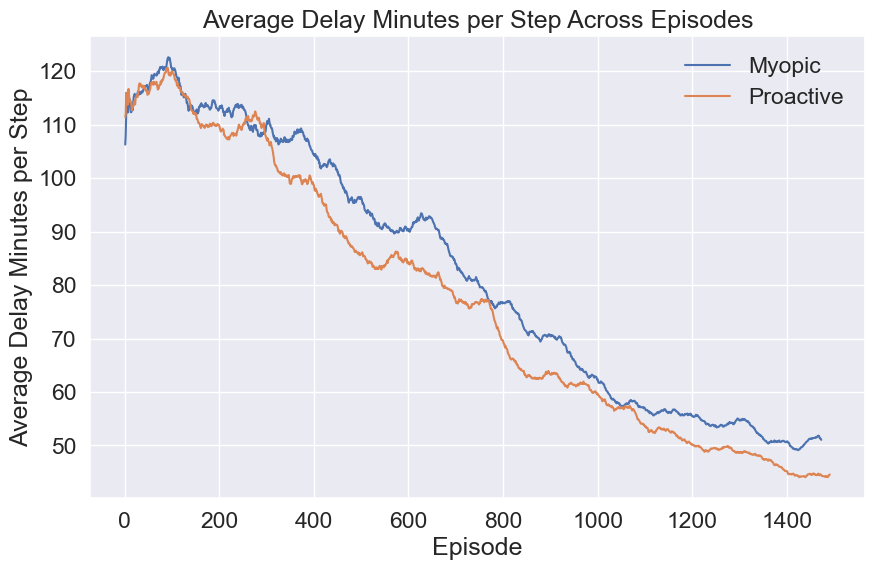

In [33]:
# %%
def calculate_avg_delay_per_step(data):
    episode_avg_delay_minutes = []
    episodes = []
    episode_std_dev = []  # To store standard deviation for each episode
    
    # Iterate through episodes
    for episode_number, episode_data in data['episodes'].items():
        total_delay_minutes = 0
        total_steps = 0
        delay_values = []  # To calculate standard deviation
        
        # Iterate through scenarios in episode
        for scenario_number in episode_data['scenarios']:
            scenario_data = episode_data['scenarios'][scenario_number]
            steps = scenario_data['steps']
            
            # Sum up delay minutes from all steps
            for step in steps:
                delay = step['info_after_step']['delay_penalty_minutes']
                delay_values.append(delay)
                total_delay_minutes += delay
                total_steps += 1
        
        # Calculate average delay minutes for the episode
        if total_steps > 0:
            avg_delay = total_delay_minutes / total_steps
            std_dev = np.std(delay_values)  # Calculate standard deviation
            episode_avg_delay_minutes.append(avg_delay)
            episodes.append(int(episode_number))
            episode_std_dev.append(std_dev)
        else:
            episode_avg_delay_minutes.append(0)
            episode_std_dev.append(0)
    
    return episodes, episode_avg_delay_minutes, episode_std_dev
# Calculate for both datasets
episodes_myopic, avg_delay_myopic, std_dev_myopic = calculate_avg_delay_per_step(data_myopic)
episodes_proactive, avg_delay_proactive, std_dev_proactive = calculate_avg_delay_per_step(data_proactive)

# Plot the data
plt.figure(figsize=(10, 6))
myopic_smooth = pd.Series(avg_delay_myopic).rolling(window=WINDOW_SIZE, min_periods=1).mean()
proactive_smooth = pd.Series(avg_delay_proactive).rolling(window=WINDOW_SIZE, min_periods=1).mean()
plt.plot(episodes_myopic, myopic_smooth, label='Myopic')
plt.plot(episodes_proactive, proactive_smooth, label='Proactive')
plt.title('Average Delay Minutes per Step Across Episodes')
plt.xlabel('Episode')
plt.ylabel('Average Delay Minutes per Step')
plt.legend(frameon=False)
plt.grid(True)
plt.show()


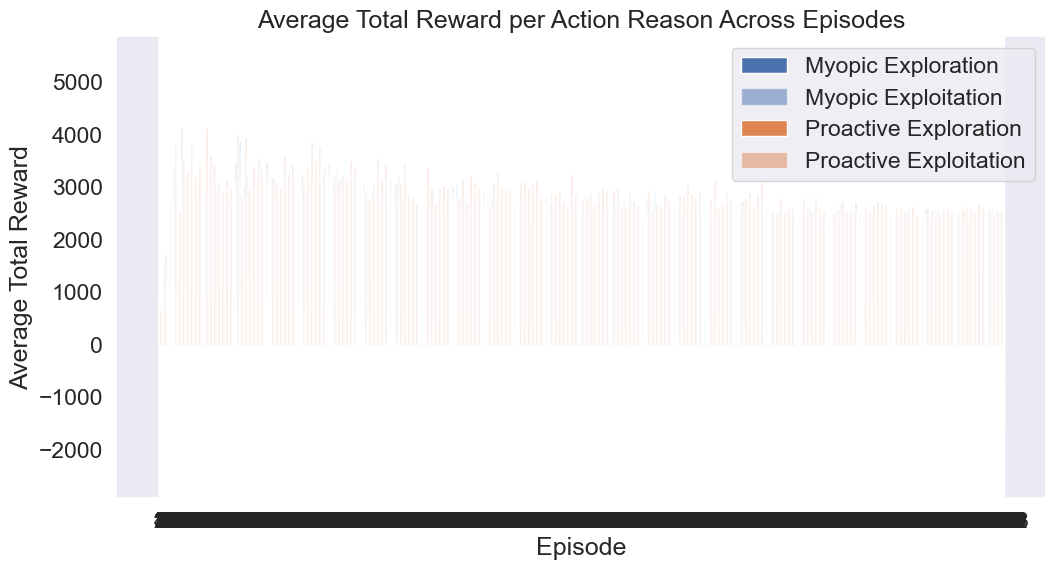

In [12]:
# %%
def calculate_rewards_by_action_reason(data):
    episode_rewards_exploration = []
    episode_rewards_exploitation = []
    episodes = []

    # Iterate through episodes to collect total rewards and action reasons
    for episode_number, episode_data in data['episodes'].items():
        total_rewards_exploration = []
        total_rewards_exploitation = []
        
        for scenario_number, scenario_data in episode_data['scenarios'].items():
            steps = scenario_data['steps']
            
            for step in steps:
                total_reward = step['info_after_step'].get('total_reward', 0)
                action_reason = step.get('action_reason')  # Assuming this field exists
                
                if action_reason == 'exploration':
                    total_rewards_exploration.append(total_reward)
                elif action_reason == 'exploitation':
                    total_rewards_exploitation.append(total_reward)

        # Calculate average total reward per action reason for the episode
        reward_exploration = np.mean(total_rewards_exploration) if total_rewards_exploration else 0
        reward_exploitation = np.mean(total_rewards_exploitation) if total_rewards_exploitation else 0

        episode_rewards_exploration.append(reward_exploration)
        episode_rewards_exploitation.append(reward_exploitation)
        episodes.append(int(episode_number))

    return episodes, episode_rewards_exploration, episode_rewards_exploitation

# Calculate for both datasets
episodes_myopic, rewards_exploration_myopic, rewards_exploitation_myopic = calculate_rewards_by_action_reason(data_myopic)
episodes_proactive, rewards_exploration_proactive, rewards_exploitation_proactive = calculate_rewards_by_action_reason(data_proactive)

# Align episodes for plotting
common_episodes = sorted(set(episodes_myopic).intersection(episodes_proactive))
indices_myopic = [episodes_myopic.index(ep) for ep in common_episodes]
indices_proactive = [episodes_proactive.index(ep) for ep in common_episodes]

rewards_exploration_myopic = [rewards_exploration_myopic[i] for i in indices_myopic]
rewards_exploitation_myopic = [rewards_exploitation_myopic[i] for i in indices_myopic]
rewards_exploration_proactive = [rewards_exploration_proactive[i] for i in indices_proactive]
rewards_exploitation_proactive = [rewards_exploitation_proactive[i] for i in indices_proactive]

# Create the bar plot
bar_width = 0.2
x = np.arange(len(common_episodes))

plt.figure(figsize=(12, 6))

plt.bar(x - bar_width*1.5, rewards_exploration_myopic, width=bar_width, label='Myopic Exploration', color='C0', alpha=1)
plt.bar(x - bar_width*0.5, rewards_exploitation_myopic, width=bar_width, label='Myopic Exploitation', color='C0', alpha=0.5)
plt.bar(x + bar_width*0.5, rewards_exploration_proactive, width=bar_width, label='Proactive Exploration', color='C1', alpha=1)
plt.bar(x + bar_width*1.5, rewards_exploitation_proactive, width=bar_width, label='Proactive Exploitation', color='C1', alpha=0.5)

plt.title('Average Total Reward per Action Reason Across Episodes')
plt.xlabel('Episode')
plt.ylabel('Average Total Reward')
plt.xticks(x, common_episodes)
plt.legend()
plt.grid(axis='y')
plt.show()


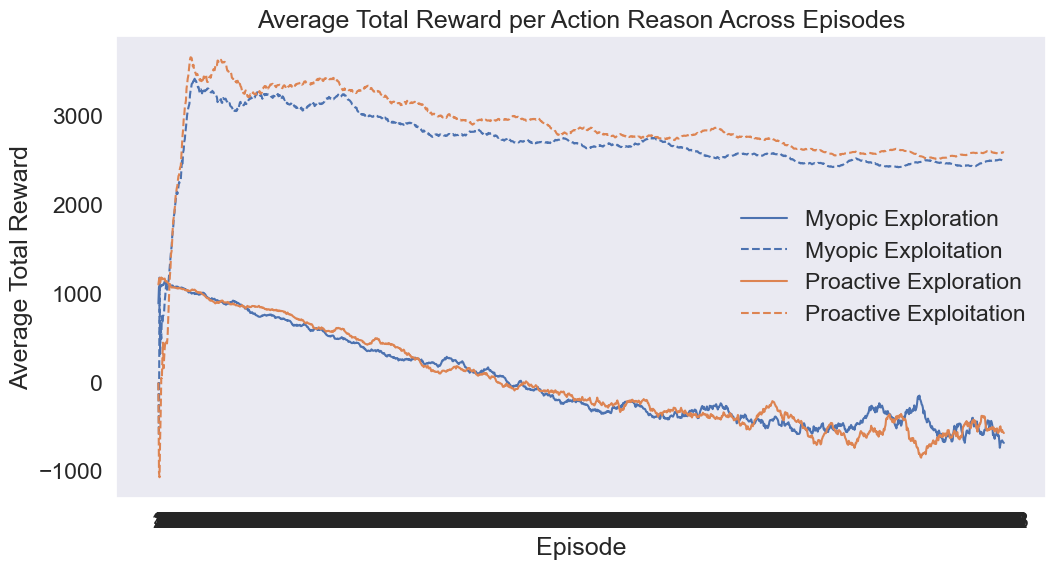

In [34]:
# %%
def calculate_rewards_by_action_reason(data):
    episode_rewards_exploration = []
    episode_rewards_exploitation = []
    episodes = []

    # Iterate through episodes to collect total rewards and action reasons
    for episode_number, episode_data in data['episodes'].items():
        total_rewards_exploration = []
        total_rewards_exploitation = []
        
        for scenario_number, scenario_data in episode_data['scenarios'].items():
            steps = scenario_data['steps']
            
            for step in steps:
                total_reward = step['info_after_step'].get('total_reward', 0)
                action_reason = step.get('action_reason')  # Assuming this field exists
                
                if action_reason == 'exploration':
                    total_rewards_exploration.append(total_reward)
                elif action_reason == 'exploitation':
                    total_rewards_exploitation.append(total_reward)

        # Calculate average total reward per action reason for the episode
        reward_exploration = np.mean(total_rewards_exploration) if total_rewards_exploration else 0
        reward_exploitation = np.mean(total_rewards_exploitation) if total_rewards_exploitation else 0

        episode_rewards_exploration.append(reward_exploration)
        episode_rewards_exploitation.append(reward_exploitation)
        episodes.append(int(episode_number))

    return episodes, episode_rewards_exploration, episode_rewards_exploitation

# Calculate for both datasets
episodes_myopic, rewards_exploration_myopic, rewards_exploitation_myopic = calculate_rewards_by_action_reason(data_myopic)
episodes_proactive, rewards_exploration_proactive, rewards_exploitation_proactive = calculate_rewards_by_action_reason(data_proactive)

# Align episodes for plotting
common_episodes = sorted(set(episodes_myopic).intersection(episodes_proactive))
indices_myopic = [episodes_myopic.index(ep) for ep in common_episodes]
indices_proactive = [episodes_proactive.index(ep) for ep in common_episodes]

rewards_exploration_myopic = [rewards_exploration_myopic[i] for i in indices_myopic]
rewards_exploitation_myopic = [rewards_exploitation_myopic[i] for i in indices_myopic]
rewards_exploration_proactive = [rewards_exploration_proactive[i] for i in indices_proactive]
rewards_exploitation_proactive = [rewards_exploitation_proactive[i] for i in indices_proactive]

# Create the line plot
plt.figure(figsize=(12, 6))
# Apply moving average smoothing
rewards_exploration_myopic_smooth = pd.Series(rewards_exploration_myopic).rolling(window=WINDOW_SIZE, min_periods=1).mean()
rewards_exploitation_myopic_smooth = pd.Series(rewards_exploitation_myopic).rolling(window=WINDOW_SIZE, min_periods=1).mean()
rewards_exploration_proactive_smooth = pd.Series(rewards_exploration_proactive).rolling(window=WINDOW_SIZE, min_periods=1).mean()
rewards_exploitation_proactive_smooth = pd.Series(rewards_exploitation_proactive).rolling(window=WINDOW_SIZE, min_periods=1).mean()

plt.plot(common_episodes, rewards_exploration_myopic_smooth, label='Myopic Exploration', color='C0')
plt.plot(common_episodes, rewards_exploitation_myopic_smooth, label='Myopic Exploitation', color='C0', linestyle='--')
plt.plot(common_episodes, rewards_exploration_proactive_smooth, label='Proactive Exploration', color='C1')
plt.plot(common_episodes, rewards_exploitation_proactive_smooth, label='Proactive Exploitation', color='C1', linestyle='--')

plt.title('Average Total Reward per Action Reason Across Episodes')
plt.xlabel('Episode')
plt.ylabel('Average Total Reward')
plt.xticks(common_episodes)
plt.legend(frameon=False)
plt.grid()
plt.show()
